# Overview

### Aim
Detect and recognise clients involve in fruadulent activities.

### Metric 
Area Under Curve (AUC)



# Set Directories

In [1]:
DataDir = '/Users/gerhardtbotha/Library/CloudStorage/GoogleDrive-gerhardtbotha5@gmail.com/My Drive/Classroom/Zindi/FraudDetectionTunisia'

TrainDir = f'{DataDir}/train'
TestDir = f'{DataDir}/test'

OutputDir = f'{DataDir}/output'

In [2]:
import os
from os import path

for pth in [TrainDir, TestDir, OutputDir]:
    if path.exists(pth) == False:
        os.mkdir(pth)

# Prepare Data

### Import libraries

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')

import numpy as np

### Read data

In [156]:
client_train = pd.read_csv(f'{TrainDir}/client_train.csv', low_memory=False)
invoice_train = pd.read_csv(f'{TrainDir}/invoice_train.csv', low_memory=False)

client_test = pd.read_csv(f'{TestDir}/client_test.csv', low_memory=False)
invoice_test = pd.read_csv(f'{TestDir}/invoice_test.csv', low_memory=False)

sample_submission = pd.read_csv(f'{DataDir}/SampleSubmission.csv', low_memory=False)

## Exploratory Analysis

### Feature Engineering

In [160]:
#convert to datetime format
for df in [invoice_train, invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [161]:
# onehot encoding

d = {'ELEC':0, 'GAZ':1}

invoice_train['counter_type'] = invoice_train['counter_type'].map(d)
invoice_test['counter_type'] = invoice_test['counter_type'].map(d)

In [164]:
#convert columns to categorical objects

for df in [client_train, client_test]:
    for col in ['client_catg', 'disrict']:
        df[col] = df[col].astype('int')

In [173]:
for col in invoice_train.columns:
    print(f'{col} - {invoice_train[col].unique()}')

client_id - ['train_Client_0' 'train_Client_1' 'train_Client_10' ...
 'train_Client_99997' 'train_Client_99998' 'train_Client_99999']
invoice_date - <DatetimeArray>
['2014-03-24 00:00:00', '2013-03-29 00:00:00', '2015-03-23 00:00:00',
 '2015-07-13 00:00:00', '2016-11-17 00:00:00', '2017-07-17 00:00:00',
 '2018-12-07 00:00:00', '2019-03-19 00:00:00', '2011-07-22 00:00:00',
 '2011-11-22 00:00:00',
 ...
 '1986-04-25 00:00:00', '1986-02-25 00:00:00', '1997-02-13 00:00:00',
 '1997-06-16 00:00:00', '1994-01-24 00:00:00', '1993-09-22 00:00:00',
 '1993-09-11 00:00:00', '1995-11-28 00:00:00', '1982-07-04 00:00:00',
 '1996-09-02 00:00:00']
Length: 8275, dtype: datetime64[ns]
tarif_type - [11 40 15 10 12 14 13 45 29  9 30  8 21 42 27 18 24]
counter_number - [1335667  678902  572765 ... 4811719  262195  560948]
counter_statue - ['0' '1' '5' '4' '3' '2' '769' 'A' '618' '269375' '46' '420']
counter_code - [203 207 413   5 467 202 420 410  10 483  25 433 407 204 214 442 453 506
 450 403 333 201 102 3

In [174]:
for col in client_train.columns:
    print(f'{col} - {client_train[col].unique()}')

disrict - [60 69 62 63]
client_id - ['train_Client_0' 'train_Client_1' 'train_Client_10' ...
 'train_Client_99997' 'train_Client_99998' 'train_Client_99999']
client_catg - [11 12 51]
region - [101 107 301 105 303 103 309 311 304 104 312 305 306 308 372 307 313 310
 371 302 106 379 399 206 199]
creation_date - ['31/12/1994' '29/05/2002' '13/03/1986' ... '16/08/2004' '30/08/1978'
 '25/05/1978']
target - [0. 1.]


,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,0
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,0
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,0
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,0
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,0


In [ ]:
invoice_train

In [19]:
#group invoice data by client_d

aggs = {}
aggs['consommation_level_1'] = ['mean']
aggs['consommation_level_2'] = ['mean']
aggs['consommation_level_3'] = ['mean']
aggs['consommation_level_4'] = ['mean']

agg_trans = invoice_train.groupby(['client_id']).agg(aggs)

agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]

agg_trans.reset_index(inplace=True)
df = (invoice_train.groupby('client_id')
          .size()
          .reset_index(name='{}transactions_count'.format('1')))

agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')

train = pd.merge(client_train,agg_trans, on='client_id', how='left')

In [165]:
#group invoice data by client_d

aggs = {}
aggs['consommation_level_1'] = ['mean']
aggs['consommation_level_2'] = ['mean']
aggs['consommation_level_3'] = ['mean']
aggs['consommation_level_4'] = ['mean']

agg_trans = invoice_test.groupby(['client_id']).agg(aggs)

agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]

agg_trans.reset_index(inplace=True)

df = (invoice_test.groupby('client_id')
          .size()
          .reset_index(name='{}transactions_count'.format('1')))

agg_trans = pd.merge(df, agg_trans, on='client_id', how='right')

test = pd.merge(client_test,agg_trans, on='client_id', how='left')

In [167]:
agg_trans

,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,test_Client_0,37,488.135135,3.243243,0.000000,0.000000
1,test_Client_1,22,1091.409091,843.136364,182.318182,586.318182
2,test_Client_10,74,554.040541,37.364865,15.743243,0.162162
3,test_Client_100,40,244.350000,0.000000,0.000000,0.000000
4,test_Client_1000,53,568.188679,145.056604,33.679245,0.000000
...,...,...,...,...,...,...
58064,test_Client_9995,4,461.250000,0.000000,0.000000,0.000000
58065,test_Client_9996,46,181.565217,0.000000,0.000000,0.000000
58066,test_Client_9997,59,160.559322,11.932203,0.000000,0.000000
58067,test_Client_9998,1,800.000000,400.000000,727.000000,0.000000


In [21]:
train.shape, test.shape

((135493, 11), (58069, 10))

In [22]:
drop_cols = ['client_id', 'creation_date']

for col in drop_cols:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [ ]:
for col in ['disrict', 'region']:
    region = train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

In [152]:
train.columns

Index(['disrict', 'client_catg', 'region', 'target', '1transactions_count',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean'],
      dtype='object')

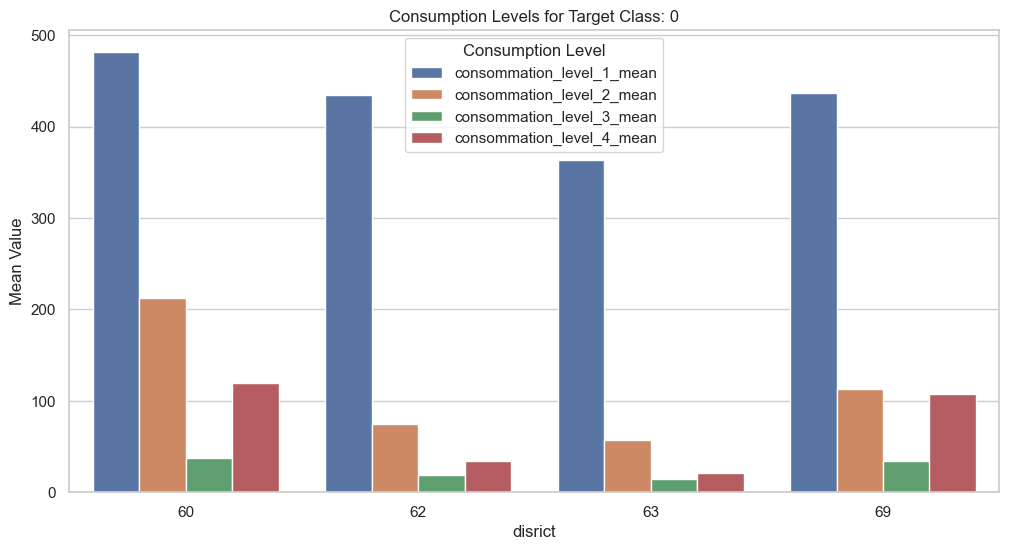

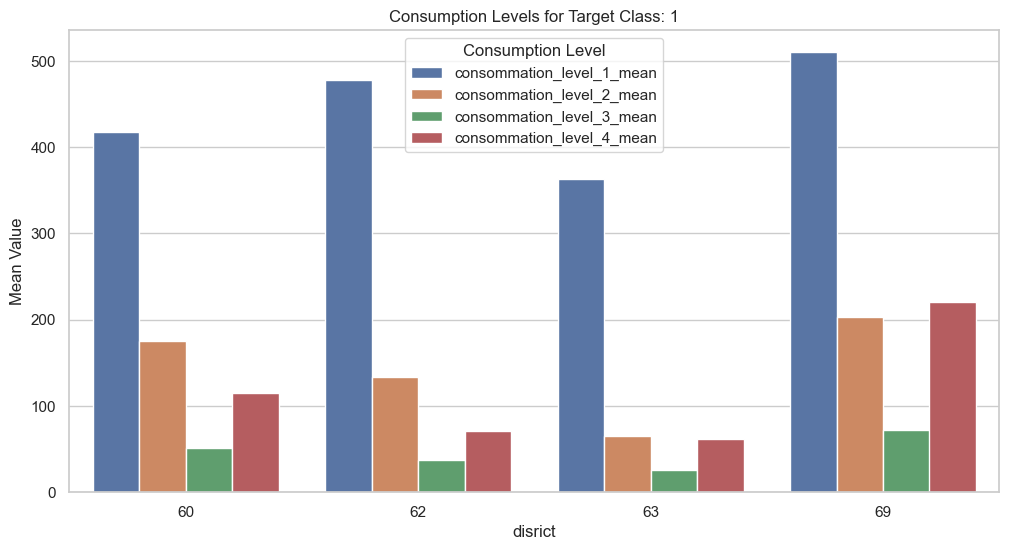

In [193]:
# Assuming 'data' is your DataFrame
features_of_interest = ['consommation_level_1_mean', 'consommation_level_2_mean',
                        'consommation_level_3_mean', 'consommation_level_4_mean']

# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a new DataFrame with selected features and the 'target' variable
plot_data = train[['target','disrict'] + features_of_interest]

# Melt the DataFrame to long format for easier plotting
melted_data = pd.melt(plot_data, id_vars=['target','disrict'], var_name='Consumption Level', value_name='Mean Value')

for i in [0, 1]:
    # Plot the bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='disrict', y='Mean Value', hue='Consumption Level', data=melted_data.loc[melted_data['target']==i], ci=None)
    plt.title(f'Consumption Levels for Target Class: {i}')
    plt.show()

**Unique Points**

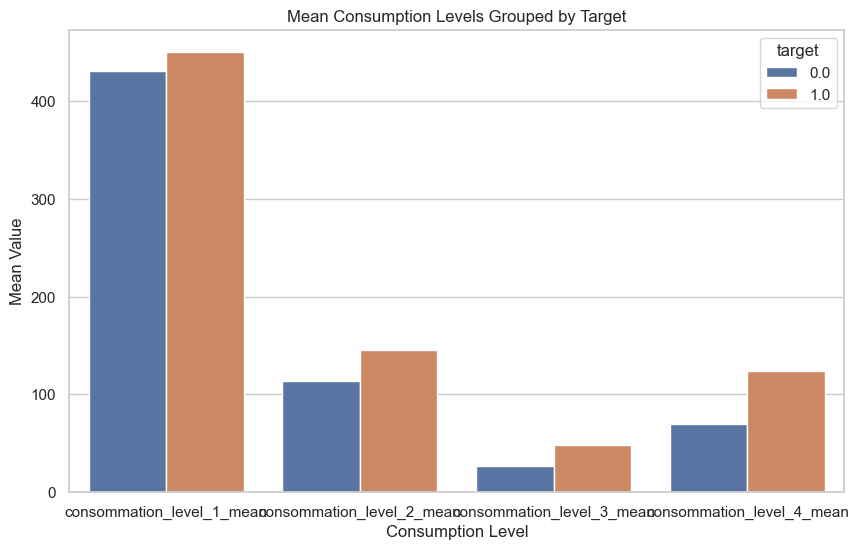

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
features_of_interest = ['consommation_level_1_mean', 'consommation_level_2_mean', 'consommation_level_3_mean', 'consommation_level_4_mean']

# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a new DataFrame with selected features and the 'target' variable
plot_data = train[['target'] + features_of_interest]

# Melt the DataFrame to long format for easier plotting
melted_data = pd.melt(plot_data, id_vars='target', var_name='Consumption Level', value_name='Mean Value')

# Plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Consumption Level', y='Mean Value', hue='target', data=melted_data, ci=None)
plt.title('Mean Consumption Levels Grouped by Target')
plt.show()

# Modelling

Will be using LightGBM gradient -- gradient boosting algorithm
More info: https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python/notebook

### Train

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection
from sklearn.model_selection import train_test_split

In [64]:
x_train = train.drop(columns=['target'])
y_train = train['target']

In [65]:
X_Train, X_Val, y_Train, y_Val = train_test_split(x_train, y_train,
                                                 stratify = y_train, test_size=0.30, 
                                                  random_state=42) 

In [66]:
# Logistic regression
model1 = LogisticRegression()

# KNN
model2 = KNeighborsClassifier()

# Fit
model1.fit(X_Train, y_Train)
model2.fit(X_Train, y_Train)

# Predict
pred_prob1 = model1.predict(X_Val)
pred_prob2 = model2.predict(X_Val)

In [67]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_Val, pred_prob1, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_Val, pred_prob2, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_Val))]
p_fpr, p_tpr, _ = roc_curve(y_Val, random_probs, pos_label=1)

In [68]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_Val, pred_prob1)
auc_score2 = roc_auc_score(y_Val, pred_prob2)

print(auc_score1, auc_score2)

0.5011249447014775 0.5054423273429183


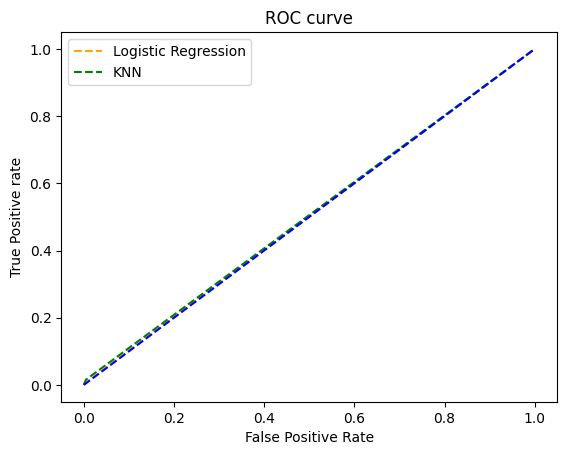

In [69]:
# matplotlib
import matplotlib.pyplot as plt
#plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [99]:
#importing LGM Clasifier
import lightgbm
from lightgbm import LGBMClassifier

# Assuming you have already trained the LightGBM model (replace model with your actual model)
model = LGBMClassifier(boosting_type='gbdt', num_iteration=500)

#Fit to training data
%time model.fit(X_Train, y_Train)

CPU times: user 5.73 s, sys: 1.04 s, total: 6.77 s
Wall time: 960 ms


LGBMClassifier(num_iteration=500)

                     Feature  Importance
4  consommation_level_1_mean        3534
3        1transactions_count        3082
5  consommation_level_2_mean        2662
6  consommation_level_3_mean        1916
7  consommation_level_4_mean        1656
2                     region        1512
0                    disrict         484
1                client_catg         154


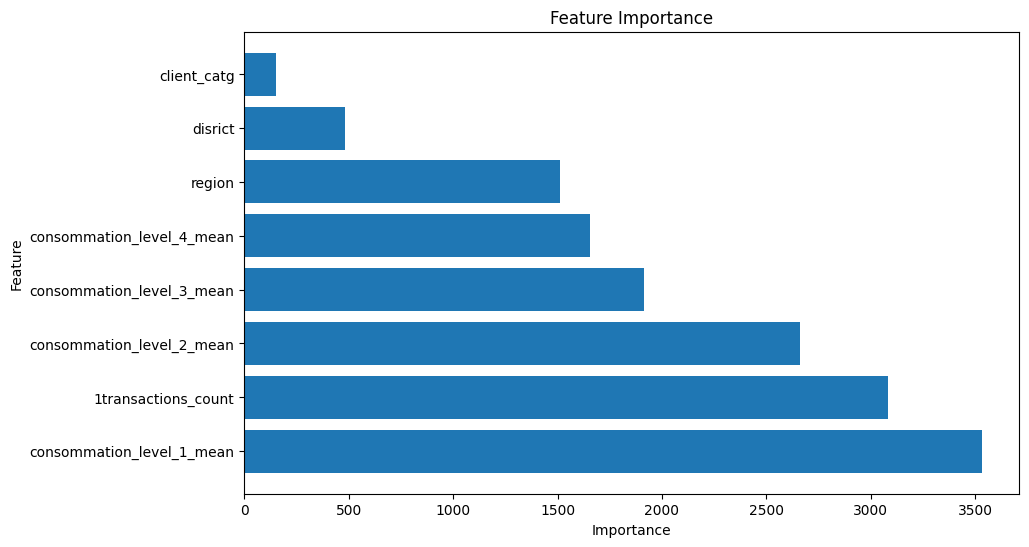

In [100]:
# Get feature importances
feature_importance = model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_Train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or display the feature importance
print(feature_importance_df)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [112]:
# Assuming you have already trained the LightGBM model (replace model with your actual model)
model = LGBMClassifier(boosting_type='gbdt', num_iteration=500)

#Fit to training data
%time model.fit(X_train_fil, y_Train)

# Assuming model is already trained and you have X_Val and y_Val
lgbm_y_prob = model.predict_proba(X_Val)[:, 1]

# Calculate AUC
auc_score_lgbm = roc_auc_score(y_Val, lgbm_y_prob)

print("AUC for LGBMClassifier:", auc_score_lgbm)

[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500
CPU times: user 776 ms, sys: 208 ms, total: 983 ms
Wall time: 212 ms


ValueError: Number of features of the model must match the input. Model n_features_ is 0 and input n_features is 8

### Make Predictions

In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score

lgbm_y_model = model.predict(X_Val)

In [95]:
# Assuming model is already trained and you have X_Val and y_Val
lgbm_y_prob = model.predict_proba(X_Val)[:, 1]

# Calculate AUC
auc_score_lgbm = roc_auc_score(y_Val, lgbm_y_prob)

print("AUC for LGBMClassifier:", auc_score_lgbm)

AUC for LGBMClassifier: 0.7331375032915104


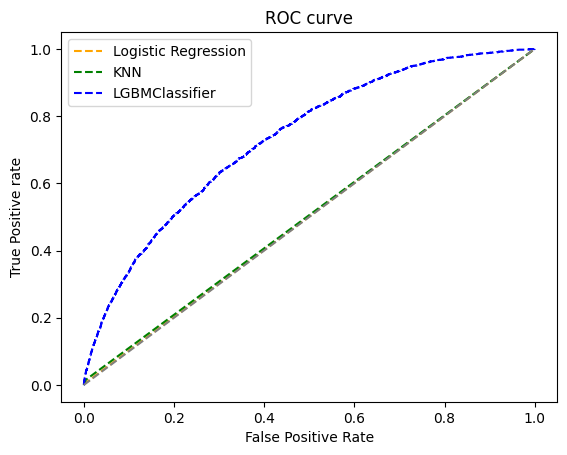

In [96]:
# matplotlib
import matplotlib.pyplot as plt

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--', color='green', label='KNN')

# Assuming model is already trained and you have X_Val and y_Val for LGBM
lgbm_y_prob = model.predict_proba(X_Val)[:, 1]
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_Val, lgbm_y_prob, pos_label=1)

# plot ROC curve for LGBM
plt.plot(fpr_lgbm, tpr_lgbm, linestyle='--', color='blue', label='LGBMClassifier')

# plot random ROC curve
plt.plot(p_fpr, p_tpr, linestyle='--', color='gray')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC', dpi=300)
plt.show()

In [81]:
print(accuracy_score(y_Val, lgbm_y_model))

0.943785672111789


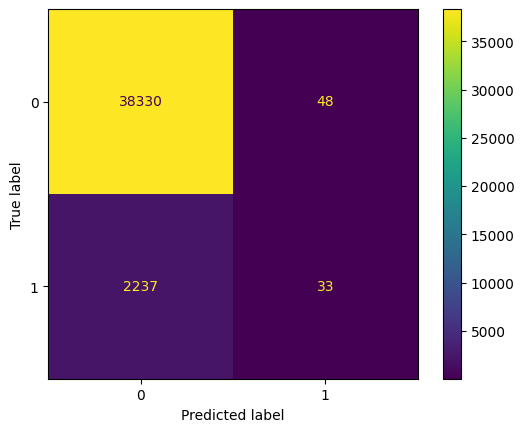

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_Val, lgbm_y_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

In [90]:
# Use predict_proba instead of predict
preds_prob = model.predict_proba(test)[:, 1]

# Create a DataFrame with probabilities
preds_prob = pd.DataFrame({'probability': preds_prob})

In [92]:
submission = pd.DataFrame(
    {
        'client_id': client_test['client_id'],
        'target': preds_prob['probability']
    }
)

In [93]:
submission

,client_id,target
0,test_Client_0,0.061538
1,test_Client_1,0.138786
2,test_Client_10,0.037949
3,test_Client_100,0.037281
4,test_Client_1000,0.032386
...,...,...
58064,test_Client_9995,0.000236
58065,test_Client_9996,0.049288
58066,test_Client_9997,0.144735
58067,test_Client_9998,0.003755
